In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

Individual 1
start_income 0.9123620356542088
peak_income 6.511285751537849
pension 4.078392730173686
------------------------------------------------------------
Individual 2
start_income 0.8467983561008608
peak_income 4.904550501902759
pension 4.239411374929922
------------------------------------------------------------


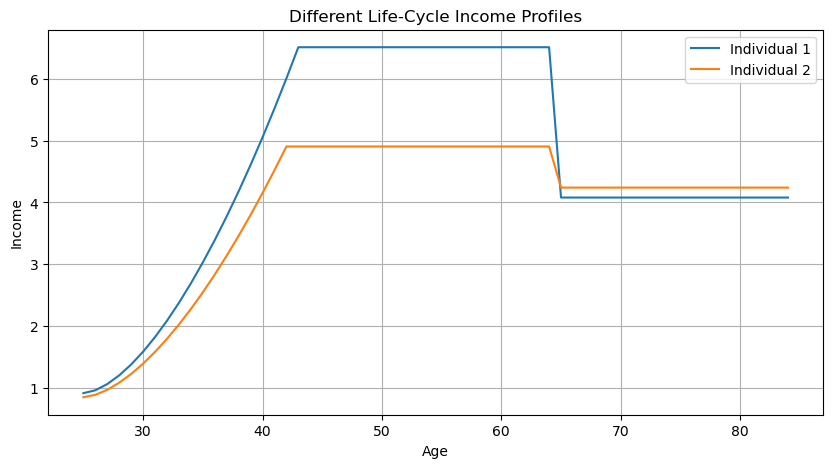

In [2]:
np.random.seed(42) 

 
# Base parameters for income
age_start, age_peak, age_retire, age_end = 25, 45, 65, 85
base_start_income, base_peak_income, base_pension = 1, 6, 4

num_individuals = 2

num_years = age_end - age_start
income_arr = np.zeros((num_individuals, num_years))


plt.figure(figsize=(10, 5))

for i in range(num_individuals):
    start_income = base_start_income * np.random.uniform(0.8, 1.1)
    peak_income = base_peak_income * np.random.uniform(0.8, 1.1)
    pension = base_pension * np.random.uniform(0.8, 1.1)
    
    print(f"Individual {i+1}")
    print(f"start_income {start_income}")
    print(f"peak_income {peak_income}")
    print(f"pension {pension}")
    print("-"*60)
    
    # Randomize career growth pattern
    peak_age = age_peak + np.random.randint(-5, 5)  # Vary peak age by ±5 years
    
    # Create income profile
    ages = np.arange(age_start, age_end) 
    income = np.zeros_like(ages,dtype=float)
    
    growth_years = peak_age - age_start
    
    # Quadratic growth with some randomness in the curve
    growth_curve = (np.linspace(0, 1, growth_years) ** np.random.uniform(1.5,2.5))
    income[:growth_years] = start_income + (peak_income - start_income) * growth_curve
    
    # Plateau until retirement
    income[growth_years : age_retire - age_start] = peak_income
    
    # Retirement
    income[age_retire - age_start :] = pension
    
    # Store this individual's income in the array
    income_arr[i, :] = income
    
    # Plot each individual's profile
    plt.plot(ages, income, label=f'Individual {i+1}')

plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Different Life-Cycle Income Profiles')
plt.grid(True)
plt.legend()
plt.show()

## Saving and Consumption without Borrowing Cost

In [3]:
def utility_including_budgetT(c,I_array,r_array,e,q):
    utility=0
    s=0
    s_arr = np.zeros(len(I_array)) 
    
    for i in range(len(c)):
        utility += (1/(1+q))**i*c[i]**e
        s = s*(1+r_array[i])+I_array[i]-c[i] 
        s_arr[i] = s
    
    s = s * (1 + r_array[len(c)])
    s_arr[len(c)] = s  # append last savings
    lastc= s+I_array[len(c)]
    utility += (1/(1+q))**len(c)*lastc**e
    return - utility, lastc, s_arr

def utility_including_budgetT_wrapper(c, I_array, r_array, e, q):
    utility, _, _ = utility_including_budgetT(c, I_array, r_array, e, q)
    return utility

C:\Users\yinsiyuan\AppData\Local\Temp\ipykernel_3752\1592869837.py:14: RuntimeWarning: invalid value encountered in scalar power
  utility += (1/(1+q))**len(c)*lastc**e


Individual 1
Utility 41.07323443033167
PV Income 154.3014082299224
PV Consumption 154.3014082299224
------------------------------------------------------------
Individual 2
Utility 40.33742429561663
PV Income 128.78417026387353
PV Consumption 128.78417026387353
------------------------------------------------------------


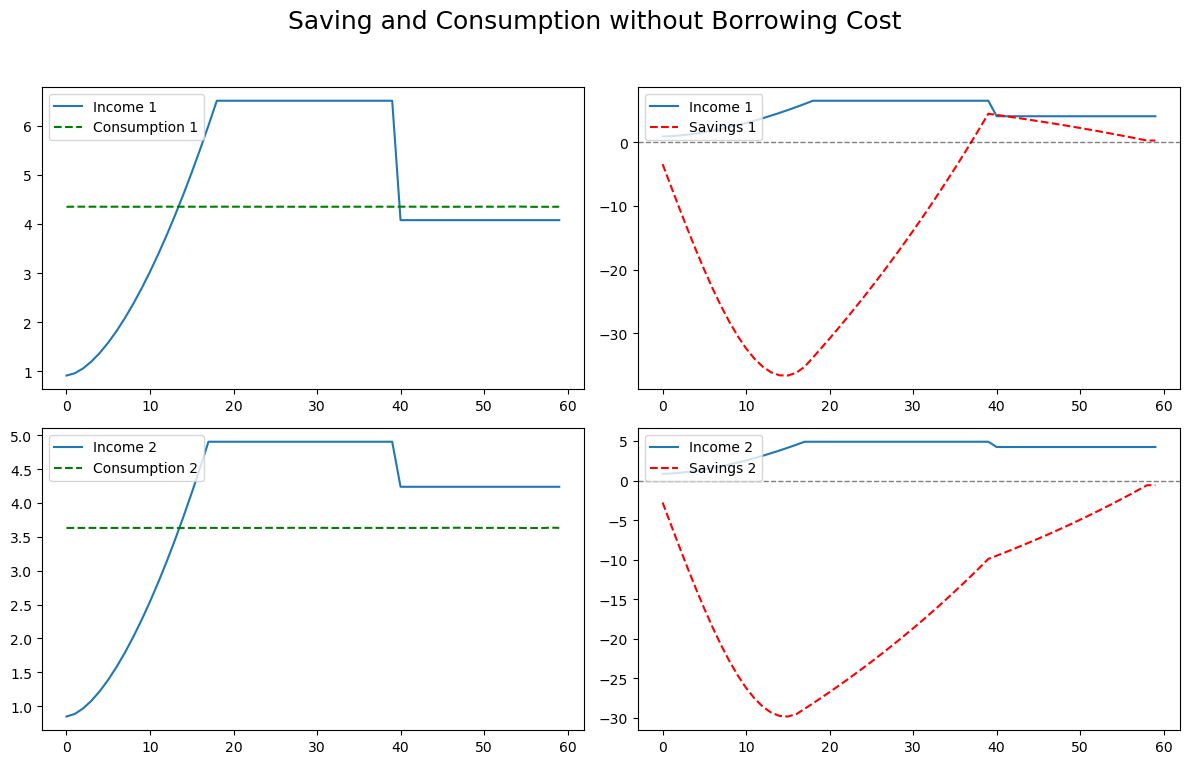

In [4]:
interest_rate = np.ones(num_years)*0.02
e = 0.1
q = interest_rate[0]

fig, axs = plt.subplots(num_individuals, 2, figsize=(12, 4 * num_individuals))

for i in range(len(income_arr)):
    income = income_arr[i]
    
    start_c = income[:-1]*0.6
    
    res1 = opt.minimize(utility_including_budgetT_wrapper,
                       start_c,
                       method='Nelder-Mead',
                       args=(income, interest_rate, e, q))
    
    res2 = opt.minimize(utility_including_budgetT_wrapper,
                       res1['x'],
                       method='BFGS',
                       args=(income, interest_rate, e, q))
    
    opt_u = res2.fun
    opt_c = res2['x']

    _, lastc, s_arr = utility_including_budgetT(opt_c,income,interest_rate,e,q)
    
    opt_c = np.append(opt_c, lastc)
    
    discount_factors = (1 / (1 + q)) ** np.arange(len(income))
    pv_income = np.sum(discount_factors * income)
    pv_consumption = np.sum(discount_factors * opt_c)
    
    
    axs[i, 0].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 0].plot(range(len(income)), opt_c, '--', label=f'Consumption {i+1}', color='g')
    axs[i, 0].legend(loc='upper left')


    axs[i, 1].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 1].plot(range(len(income)), s_arr, '--', label=f'Savings {i+1}', color='r')
    axs[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[i, 1].legend(loc='upper left')
    
    print(f"Individual {i+1}")
    print(f"Utility {-opt_u}")   
    print(f"PV Income {pv_income}")
    print(f"PV Consumption {pv_consumption}")
    print("-"*60)
    
fig.suptitle("Saving and Consumption without Borrowing Cost", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Saving and Consumption with Borrowing Cost

In [5]:
def utility_including_budgetT2(c, I_array, r_array, e, q, penalty):
    utility = 0
    s = 0
    s_arr = np.zeros(len(I_array))
    penalty_arr = np.zeros(len(I_array))

    for i in range(len(c)):
        utility += (1/(1+q))**i * c[i]**e

        if s > 0:
            s = s * (1 + r_array[i]) + I_array[i] - c[i]
        else:
            penalty_interest = s * penalty
            penalty_arr[i] = abs(penalty_interest)
            s = s * (1 + r_array[i] + penalty) + I_array[i] - c[i]

        s_arr[i] = s


    if s > 0:
        s = s * (1 + r_array[len(c)])
    else:
        penalty_interest = s * penalty
        penalty_arr[len(c)] = abs(penalty_interest)
        s = s * (1 + r_array[len(c)] + penalty)

    s_arr[len(c)] = s  
    lastc = s + I_array[len(c)]
    utility += (1/(1+q))**len(c) * lastc**e

    return -utility, lastc, s_arr, penalty_arr

def utility_including_budgetT2_wrapper(c, I_array, r_array, e, q, penalty):
    utility, _, _, _ = utility_including_budgetT2(c, I_array, r_array, e, q, penalty)
    return utility

C:\Users\yinsiyuan\AppData\Local\Temp\ipykernel_3752\3062388845.py:8: RuntimeWarning: invalid value encountered in scalar power
  utility += (1/(1+q))**i * c[i]**e
C:\Users\yinsiyuan\AppData\Local\Temp\ipykernel_3752\3062388845.py:29: RuntimeWarning: invalid value encountered in scalar power
  utility += (1/(1+q))**len(c) * lastc**e


Individual 1
Utility 40.67624955712988
PV Income 154.3014082299224
PV Consumption 149.37564443263167
PV Penalty Cost 4.9257637972907276
PV Consumption + Penalty Cost 154.3014082299224
------------------------------------------------------------
Individual 2
Utility 39.963000590063295
PV Income 128.78417026387353
PV Consumption 125.3669652807963
PV Penalty Cost 3.4172049830772377
PV Consumption + Penalty Cost 128.78417026387353
------------------------------------------------------------


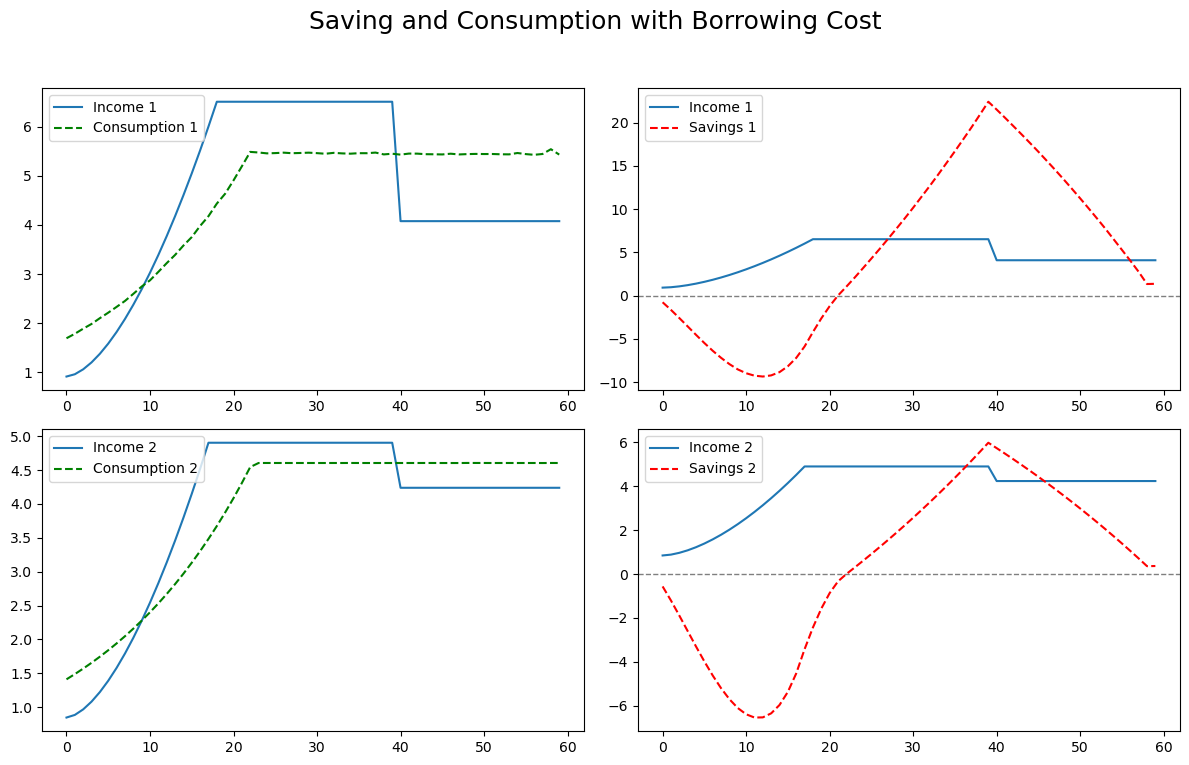

In [6]:
interest_rate = np.ones(num_years)*0.02
e = 0.1
q = interest_rate[0]
penalty = 0.05

fig, axs = plt.subplots(num_individuals, 2, figsize=(12, 4 * num_individuals))

for i in range(len(income_arr)):
    income = income_arr[i]
    
    start_c = income[:-1]*0.6
    
    res1 = opt.minimize(utility_including_budgetT2_wrapper,
                       start_c,
                       method='Nelder-Mead',
                       args=(income, interest_rate, e, q, penalty))
    
    res2 = opt.minimize(utility_including_budgetT2_wrapper,
                       res1['x'],
                       method='BFGS',
                       args=(income, interest_rate, e, q, penalty))
    
    opt_u = res2.fun
    opt_c = res2['x']

    _, lastc, s_arr, penalty_arr = utility_including_budgetT2(opt_c,income,interest_rate,e,q, penalty)
    
    opt_c = np.append(opt_c, lastc)
    
    discount_factors = (1 / (1 + q)) ** np.arange(len(income))
    pv_income = np.sum(discount_factors * income)
    pv_consumption = np.sum(discount_factors * opt_c)
    pv_penalty = np.sum(discount_factors * penalty_arr)
    
    
    axs[i, 0].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 0].plot(range(len(income)), opt_c, '--', label=f'Consumption {i+1}', color='g')
    axs[i, 0].legend(loc='upper left')

    axs[i, 1].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 1].plot(range(len(income)), s_arr, '--', label=f'Savings {i+1}', color='r')
    axs[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[i, 1].legend(loc='upper left')
    
    
    print(f"Individual {i+1}")
    print(f"Utility {-opt_u}")   
    print(f"PV Income {pv_income}")
    print(f"PV Consumption {pv_consumption}")
    print(f"PV Penalty Cost {pv_penalty}")
    print(f"PV Consumption + Penalty Cost {pv_consumption+pv_penalty}")
    print("-"*60)
    
fig.suptitle("Saving and Consumption with Borrowing Cost", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Renter's Consumption of Varying Housing and Other Goods without Borrowing Cost

In [7]:
def utility_with_varying_housing_no_penalty(c, I_array, r_array, e, q):
    num_periods = len(I_array)
    s = 0
    utility = 0
    s_arr = np.zeros(num_periods)
    
    
    c_other = c[:num_periods-1]
    c_housing = c[num_periods-1:]
    
    for i in range(len(c_other)):
        h = c_housing[i]
        co = c_other[i]
        utility += (1/(1+q))**i * ((h**0.4) * (co**0.6))**e
        s = s * (1 + r_array[i]) + I_array[i] - co - h 
        s_arr[i] = s

    s = s * (1 + r_array[len(c_other)])
    
    s_arr[len(c_other)] = s
    lasth = c_housing[-1] # assume the lasth = the nearest h
    lastc = s + I_array[len(c_other)] - lasth
    last_utility = ((lasth**0.4) * (lastc**0.6))**e
    utility += (1/(1+q))**len(c_other) * last_utility

    return -utility, lastc, lasth, s_arr

def utility_with_varying_housing_no_penalty_wrapper(c, I_array, r_array, e, q):
    utility, _, _, _,  = utility_with_varying_housing_no_penalty(c, I_array, r_array, e, q)
    return utility

Individual 1
Utility 38.39992526155777
PV Income 154.3014082299224
PV Consumption 92.58065941750257
PV Housing 61.72074881241982
PV Consumption + Housing 154.3014082299224
------------------------------------------------------------
Individual 2
Utility 37.71200637959942
PV Income 128.78417026387353
PV Consumption 77.26990143085969
PV Housing 51.51426883301383
PV Consumption + Housing 128.78417026387353
------------------------------------------------------------


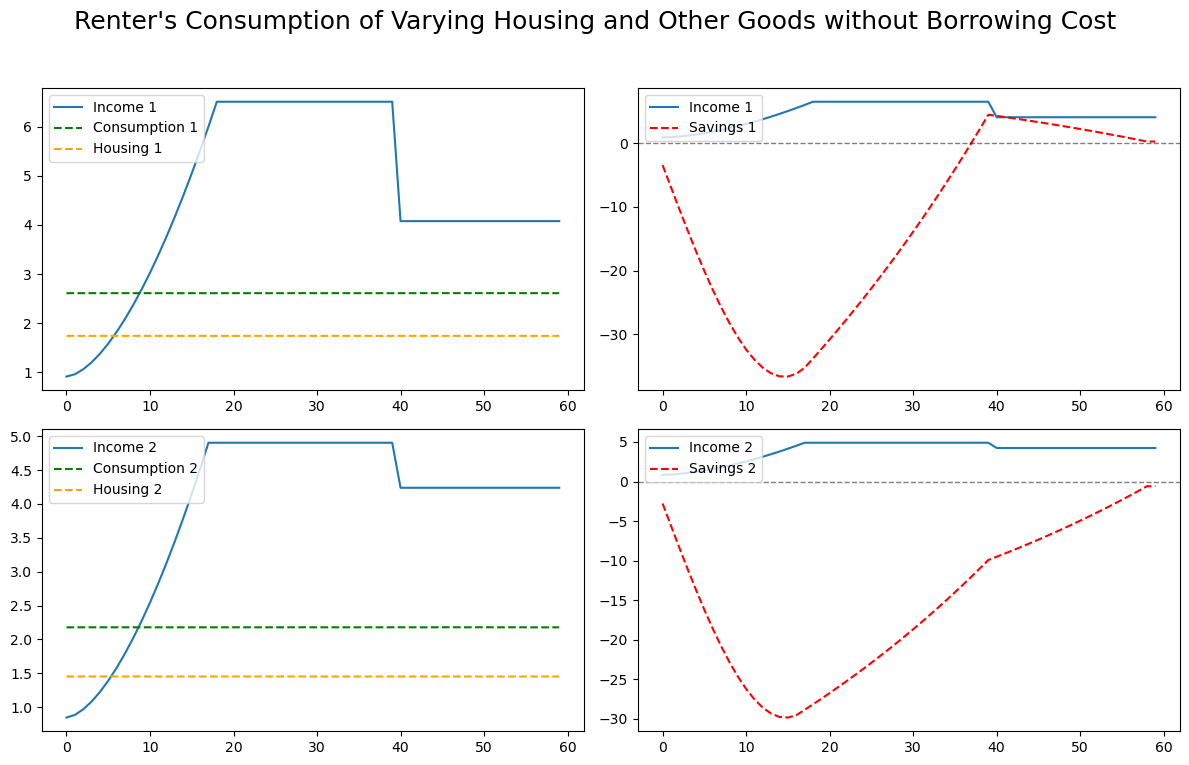

In [8]:
interest_rate = np.ones(num_years)*0.02
e = 0.1
q = interest_rate[0]

fig, axs = plt.subplots(num_individuals, 2, figsize=(12, 4 * num_individuals))


for i in range(len(income_arr)):
    income = income_arr[i]
    
    start_c = income[:-1]*0.6
    start_housing = income[:-1]*0.4
    start_c = np.concatenate((start_c, start_housing))
    
    res1 = opt.minimize(utility_with_varying_housing_no_penalty_wrapper,
                       start_c,
                       method='Nelder-Mead',
                       args=(income, interest_rate, e, q))

    
    res2 = opt.minimize(utility_with_varying_housing_no_penalty_wrapper,
                       res1['x'],
                       method='BFGS',
                       args=(income, interest_rate, e, q))

    opt_u = res2.fun
    opt_x = res2.x
    opt_c = res2.x[:len(income)-1]
    opt_h = res2.x[len(income)-1:]
    
    opt_c_combined = np.concatenate((opt_c, opt_h))
    
    _, lastc, h_last, s_arr = utility_with_varying_housing_no_penalty(opt_c_combined,income, interest_rate, e, q)
    
    opt_c = np.append(opt_c, lastc)
    opt_h = np.append(opt_h, h_last)
    
    
    discount_factors = (1 / (1 + q)) ** np.arange(len(income))
    pv_income = np.sum(discount_factors * income)
    pv_consumption = np.sum(discount_factors * opt_c)
    pv_housing = np.sum(discount_factors * opt_h )
    
    axs[i, 0].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 0].plot(range(len(income)), opt_c, '--', label=f'Consumption {i+1}',color='g')
    axs[i, 0].plot(range(len(income)), opt_h, '--', label=f'Housing {i+1}',color='orange')
    axs[i, 0].legend(loc='upper left')
    
    axs[i, 1].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 1].plot(range(len(income)), s_arr, '--', label=f'Savings {i+1}',color='r')
    axs[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[i, 1].legend(loc='upper left')
    

    print(f"Individual {i+1}")
    print(f"Utility {-opt_u}")   
    print(f"PV Income {pv_income}")
    print(f"PV Consumption {pv_consumption}")
    print(f"PV Housing {pv_housing}")
    print(f"PV Consumption + Housing {pv_consumption+pv_housing}")
    
    print("-"*60) 
    
fig.suptitle("Renter's Consumption of Varying Housing and Other Goods without Borrowing Cost", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Renter's Consumption of Varying Housing and Other Goods with Borrowing Cost

In [9]:
def utility_with_varying_housing(c, I_array, r_array, e, q, penalty):
    num_periods = len(I_array)
    s = 0
    utility = 0
    s_arr = np.zeros(num_periods)
    penalty_arr = np.zeros(num_periods)
    
    
    c_other = c[:num_periods-1]
    c_housing = c[num_periods-1:]
    
    for i in range(len(c_other)):
        h = c_housing[i]
        co = c_other[i]
        utility += (1/(1+q))**i * ((h**0.4) * (co**0.6))**e
        
        if s > 0:
            s = s * (1 + r_array[i]) + I_array[i] - co - h
        else:
            penalty_interest = s * penalty
            penalty_arr[i] = abs(penalty_interest)
            s = s * (1 + r_array[i] + penalty) + I_array[i] - co -h

        s_arr[i] = s
        
    h_last = c_housing[-1]
        
    if s > 0:
        s = s * (1 + r_array[len(c_other)])
    else:
        penalty_interest = s * penalty
        penalty_arr[len(c_other)] = abs(penalty_interest)
        s = s * (1 + r_array[len(c_other)] + penalty)
        
    s_arr[len(c_other)] = s
    lastc = s + I_array[len(c_other)] - h_last
    last_utility = ((h_last**0.4) * (lastc**0.6))**e
    utility += (1/(1+q))**len(c_other) * last_utility

    return -utility, lastc, h_last, s_arr, penalty_arr

def utility_with_varying_housing_wrapper(c, I_array, r_array, e, q, penalty):
    utility, _, _, _, _ = utility_with_varying_housing(c, I_array, r_array, e, q, penalty)
    return utility

C:\Users\yinsiyuan\AppData\Local\Temp\ipykernel_3752\1250302848.py:37: RuntimeWarning: invalid value encountered in scalar power
  last_utility = ((h_last**0.4) * (lastc**0.6))**e


Individual 1
Utility 38.028792735598365
PV Income 154.3014082299224
PV Consumption 89.59253709353834
PV Housing 59.77049783718507
PV Penalty Cost 4.938373299198977
PV Consumption + Housing + Penalty Cost 154.3014082299224
------------------------------------------------------------
Individual 2
Utility 37.36195251113521
PV Income 128.78417026387353
PV Consumption 75.22067441569469
PV Housing 50.146424645731464
PV Penalty Cost 3.4170712024473504
PV Consumption + Housing + Penalty Cost 128.7841702638735
------------------------------------------------------------


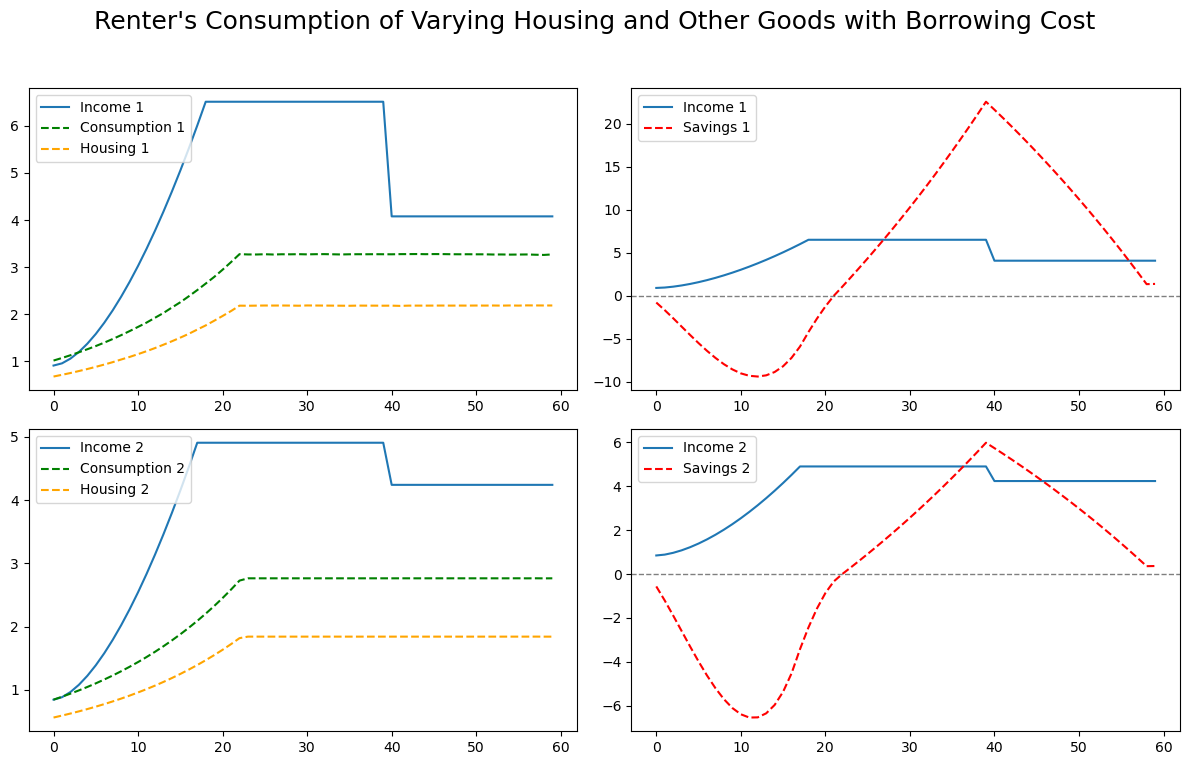

In [10]:
interest_rate = np.ones(num_years)*0.02
e = 0.1
q = interest_rate[0]
penalty = 0.05

fig, axs = plt.subplots(num_individuals, 2, figsize=(12, 4 * num_individuals))

for i in range(len(income_arr)):
    income = income_arr[i]
    
    start_c = income[:-1]*0.6
    start_housing = income[:-1]*0.4
    start_c = np.concatenate((start_c, start_housing))
    
    res1 = opt.minimize(utility_with_varying_housing_wrapper,
                       start_c,
                       method='Nelder-Mead',
                       args=(income, interest_rate, e, q, penalty))

    
    res2 = opt.minimize(utility_with_varying_housing_wrapper,
                       res1['x'],
                       method='BFGS',
                       args=(income, interest_rate, e, q, penalty))

    opt_u = res2.fun
    opt_x = res2.x
    opt_c = res2.x[:len(income)-1]
    opt_h = res2.x[len(income)-1:]
    
    opt_c_combined = np.concatenate((opt_c, opt_h))
    
    _, lastc, h_last, s_arr, penalty_arr = utility_with_varying_housing(opt_c_combined,income,interest_rate,e,q, penalty)
    
    opt_c = np.append(opt_c, lastc)
    opt_h = np.append(opt_h, h_last)
    
    
    discount_factors = (1 / (1 + q)) ** np.arange(len(income))
    pv_income = np.sum(discount_factors * income)
    pv_consumption = np.sum(discount_factors * opt_c)
    pv_housing = np.sum(discount_factors * opt_h)
    pv_penalty = np.sum(discount_factors * penalty_arr)
    
    axs[i, 0].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 0].plot(range(len(income)), opt_c, '--', label=f'Consumption {i+1}',color='g')
    axs[i, 0].plot(range(len(income)), opt_h, '--', label=f'Housing {i+1}',color='orange')
    axs[i, 0].legend(loc='upper left')
    
    axs[i, 1].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 1].plot(range(len(income)), s_arr, '--', label=f'Savings {i+1}',color='r')
    axs[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[i, 1].legend(loc='upper left')
    
    print(f"Individual {i+1}")
    print(f"Utility {-opt_u}")   
    print(f"PV Income {pv_income}")
    print(f"PV Consumption {pv_consumption}")
    print(f"PV Housing {pv_housing}")
    print(f"PV Penalty Cost {pv_penalty}")
    print(f"PV Consumption + Housing + Penalty Cost {pv_consumption+pv_housing+pv_penalty}")
    print("-"*60)
    
fig.suptitle("Renter's Consumption of Varying Housing and Other Goods with Borrowing Cost", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Homeowners' Consumption of Other Goods with Fixed Housing without Borrowing Cost

In [11]:
def utility_with_fixed_housing_no_penalty(c, I_array, r_array, e, q):
    num_periods = len(I_array)
    s = 0
    utility = 0
    s_arr = np.zeros(num_periods)
    
    c_housing = c[-1]
    c_other = c[:num_periods-1]
    
    for i in range(len(c_other)):
        utility += (1/(1+q))**i * ((c_housing**0.4) * (c_other[i]**0.6))**e
        s = s * (1 + r_array[i]) + I_array[i] - c_other[i] - c_housing
        s_arr[i] = s
        
    s = s * (1 + r_array[len(c_other)])
    
    s_arr[len(c_other)] = s
    lastc = s + I_array[len(c_other)] - c_housing
    last_utility = ((c_housing**0.4) * (lastc**0.6))**e
    utility += (1/(1+q))**len(c_other) * last_utility
    
    return -utility, lastc, s_arr

def utility_with_fixed_housing_no_penalty_wrapper(c, I_array, r_array, e, q):
    utility, _, _ = utility_with_fixed_housing_no_penalty(c, I_array, r_array, e, q)
    return utility

Individual 1
Utility 38.39992497983569
PV Income 154.3014082299224
PV Consumption 92.56973552563466
PV Housing 61.731672704287774
PV Consumption + Housing 154.30140822992243
------------------------------------------------------------
Individual 2
Utility 37.71200485885154
PV Income 128.78417026387353
PV Consumption 77.28088225027199
PV Housing 51.50328801360154
PV Consumption + Housing 128.78417026387353
------------------------------------------------------------


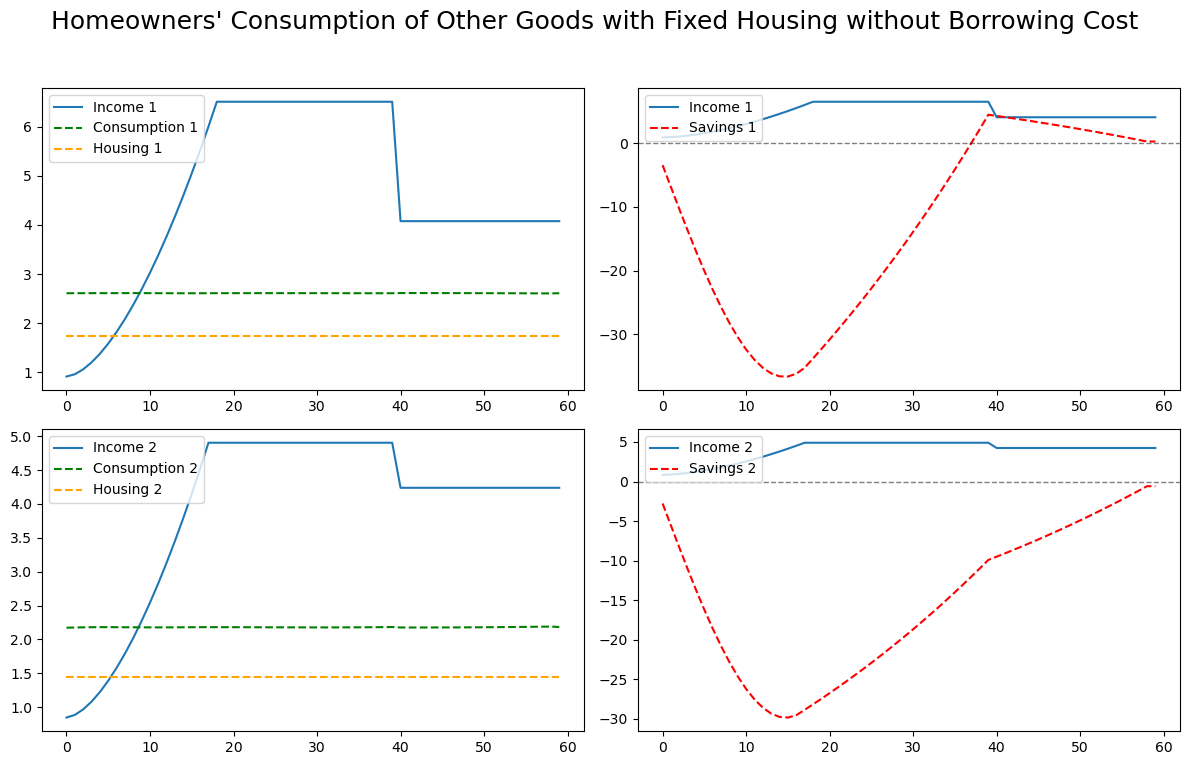

In [12]:
interest_rate = np.ones(num_years)*0.02
e = 0.1
q = interest_rate[0]

fig, axs = plt.subplots(num_individuals, 2, figsize=(12, 4 * num_individuals))

for i in range(len(income_arr)):
    income = income_arr[i]
    
    discount_factors = (1 / (1 + q)) ** np.arange(len(income))
    pv_income = np.sum(discount_factors * income)
    
    
    start_housing = np.mean(discount_factors * income)*0.68

    start_c = income[:-1]*0.6
    
    start_c = np.concatenate([start_c, np.array([start_housing])])


    bounds = [(1e-6, None)] * len(start_c)

    res2 = opt.minimize(utility_with_fixed_housing_no_penalty_wrapper,
                        start_c,
                        method='L-BFGS-B',
                        bounds=bounds,
                        args=(income, interest_rate, e, q))

    
    opt_u = res2.fun
    opt_x = res2.x
    opt_c = res2.x[:-1]
    opt_h = np.ones(len(income))*res2.x[-1]
    
    opt_combined = np.concatenate([opt_c,[opt_h[0]]])
    
    _, lastc, s_arr = utility_with_fixed_housing_no_penalty(opt_combined,income,interest_rate, e, q)
    
    opt_c = np.append(opt_c, lastc)
    

    pv_income = np.sum(discount_factors * income)
    pv_consumption = np.sum(discount_factors * opt_c)
    pv_housing = np.sum(discount_factors * opt_h)
    
    
    axs[i, 0].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 0].plot(range(len(income)), opt_c, '--', label=f'Consumption {i+1}',color='g')
    axs[i, 0].plot(range(len(income)), opt_h, '--', label=f'Housing {i+1}',color='orange')
    axs[i, 0].legend(loc='upper left')
    
    axs[i, 1].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 1].plot(range(len(income)), s_arr, '--', label=f'Savings {i+1}',color='r')
    axs[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[i, 1].legend(loc='upper left')

    
    print(f"Individual {i+1}")
    print(f"Utility {-opt_u}")   
    print(f"PV Income {pv_income}")
    print(f"PV Consumption {pv_consumption}")
    print(f"PV Housing {pv_housing}")
    print(f"PV Consumption + Housing {pv_consumption+pv_housing}")
    print("-"*60)
    
fig.suptitle("Homeowners' Consumption of Other Goods with Fixed Housing without Borrowing Cost", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Homeowners' Consumption of Other Goods with Fixed Housing with Borrowing Cost

Individual 1
start_income 2.4686774604365613
peak_income 10.339756376720343
pension 5.589136616593608
------------------------------------------------------------
Individual 2
start_income 2.6772114886689655
peak_income 8.791612517113697
pension 4.956138173711986
------------------------------------------------------------


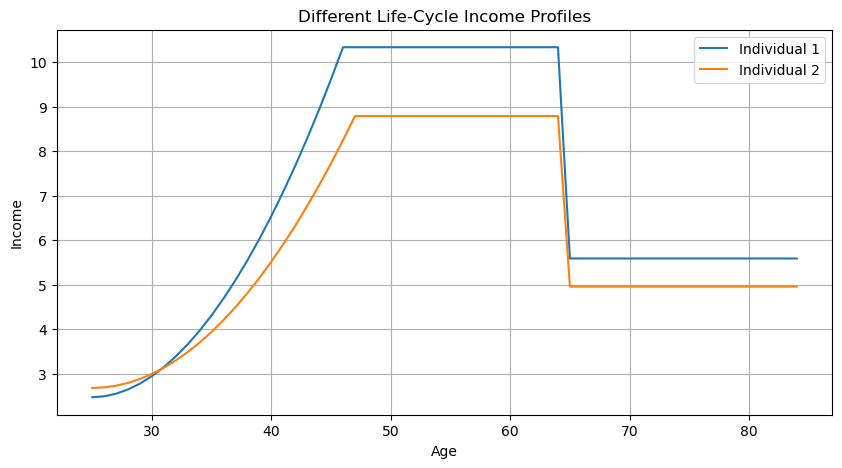

In [13]:
np.random.seed(7) 

# Base parameters for income
age_start, age_peak, age_retire, age_end = 25, 45, 65, 85
base_start_income, base_peak_income, base_pension = 3, 10, 6

num_individuals = 2

num_years = age_end - age_start
income_arr = np.zeros((num_individuals, num_years))


plt.figure(figsize=(10, 5))

for i in range(num_individuals):
    start_income = base_start_income * np.random.uniform(0.8, 1.1)
    peak_income = base_peak_income * np.random.uniform(0.8, 1.1)
    pension = base_pension * np.random.uniform(0.8, 1.1)
    
    print(f"Individual {i+1}")
    print(f"start_income {start_income}")
    print(f"peak_income {peak_income}")
    print(f"pension {pension}")
    print("-"*60)
    
    # Randomize career growth pattern
    peak_age = age_peak + np.random.randint(-5, 5)  # Vary peak age by ±5 years
    
    # Create income profile
    ages = np.arange(age_start, age_end) 
    income = np.zeros_like(ages,dtype=float)
    
    growth_years = peak_age - age_start
    
    # Quadratic growth with some randomness in the curve
    growth_curve = (np.linspace(0, 1, growth_years) ** np.random.uniform(1.5,2.5))
    income[:growth_years] = start_income + (peak_income - start_income) * growth_curve
    
    # Plateau until retirement
    income[growth_years : age_retire - age_start] = peak_income
    
    # Retirement
    income[age_retire - age_start :] = pension
    
    # Store this individual's income in the array
    income_arr[i, :] = income
    
    # Plot each individual's profile
    plt.plot(ages, income, label=f'Individual {i+1}')

plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Different Life-Cycle Income Profiles')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
def utility_with_fixed_housing(c, I_array, r_array, e, q, penalty):
    num_periods = len(I_array)
    s = 0
    utility = 0
    s_arr = np.zeros(num_periods)
    penalty_arr = np.zeros(num_periods)
    u_arr = np.zeros(num_periods)
    
    c_housing = c[-1]
    c_other = c[:-1]
    
    for i in range(len(c_other)):
        utility += (1/(1+q))**i * ((c_housing**0.4) * (c_other[i]**0.6))**e
        u_arr[i] = utility
        
        if s > 0:
            s = s * (1 + r_array[i]) + I_array[i] - c_other[i] - c_housing
        else:
            penalty_interest = s * penalty
            penalty_arr[i] = abs(penalty_interest)
            s = s * (1 + r_array[i] + penalty) + I_array[i] - c_other[i] - c_housing

        s_arr[i] = s
        
    if s > 0:
        s = s * (1 + r_array[len(c_other)])
    else:
        penalty_interest = s * penalty
        penalty_arr[len(c_other)] = abs(penalty_interest)
        s = s * (1 + r_array[len(c_other)] + penalty)
        
    s_arr[len(c_other)] = s
    
    lastc = s + I_array[len(c_other)] - c_housing
    last_utility = ((c_housing**0.4) * (lastc**0.6))**e
    utility += (1/(1+q))**len(c_other) * last_utility

    u_arr[len(c_other)] = utility
    

    return -utility, lastc, s_arr, penalty_arr, u_arr

def utility_with_fixed_housing_wrapper(c, I_array, r_array, e, q, penalty):
    utility, lastc, _, _,_ = utility_with_fixed_housing(c, I_array, r_array, e, q, penalty)
    if lastc < 0:
        utility += 1e6 + abs(lastc) * 1e6 
    return utility

C:\Users\yinsiyuan\AppData\Local\Temp\ipykernel_3752\1384175870.py:35: RuntimeWarning: invalid value encountered in scalar power
  last_utility = ((c_housing**0.4) * (lastc**0.6))**e


Individual 1
Utility 39.551821551942076
PV Income 232.71138975223653
PV Consumption 142.61841615838793
PV Housing 77.68144084401213
PV Penalty Cost 12.41153274983645
PV Consumption + Housing + Penalty Cost 232.71138975223653
------------------------------------------------------------


C:\Users\yinsiyuan\AppData\Local\Temp\ipykernel_3752\1384175870.py:35: RuntimeWarning: invalid value encountered in scalar power
  last_utility = ((c_housing**0.4) * (lastc**0.6))**e


Individual 2
Utility 39.107885543639455
PV Income 203.1235832507255
PV Consumption 126.04386836836136
PV Housing 69.7508104516008
PV Penalty Cost 7.3289044307633935
PV Consumption + Housing + Penalty Cost 203.12358325072555
------------------------------------------------------------


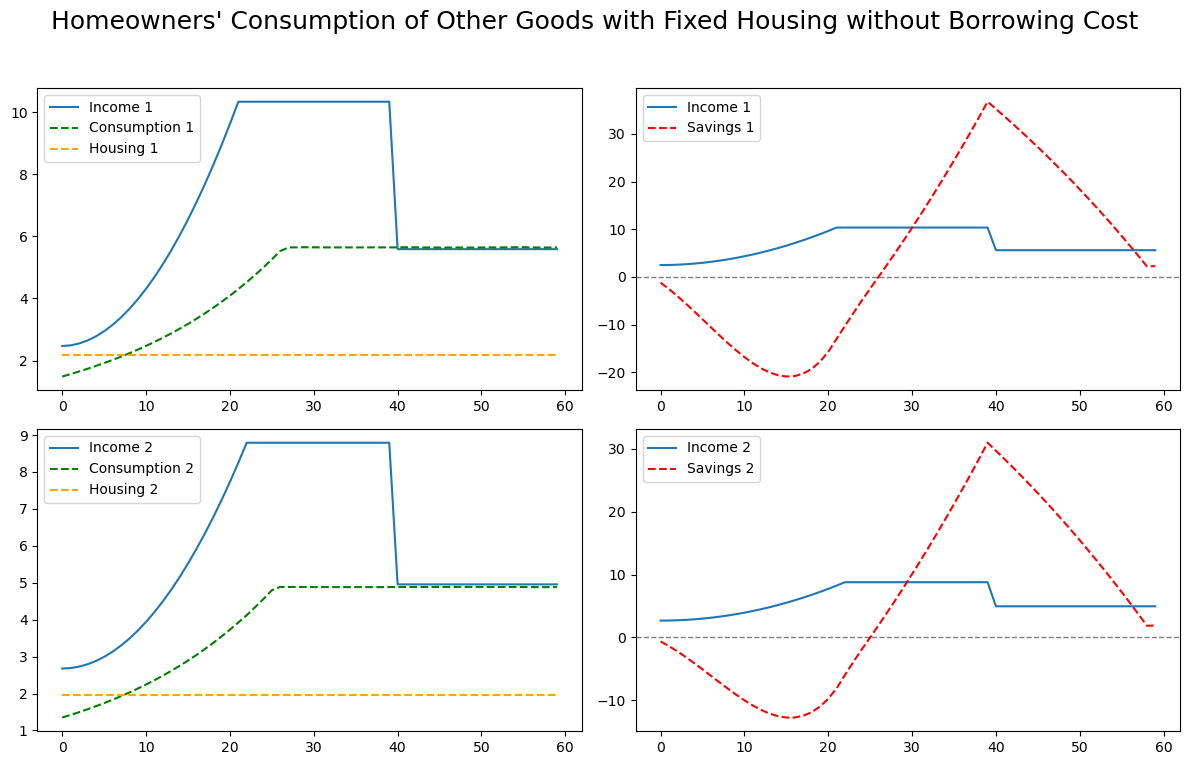

In [15]:
interest_rate = np.ones(num_years)*0.02
e = 0.1
q = interest_rate[0]
penalty = 0.05

fig, axs = plt.subplots(num_individuals, 2, figsize=(12, 4 * num_individuals))


for i in range(len(income_arr)):
    income = income_arr[i]
    
    discount_factors = (1 / (1 + q)) ** np.arange(len(income))
    pv_income = np.sum(discount_factors * income)
    
    start_h = np.mean(discount_factors * income)*0.4
    
    start_c = income[:-1]*0.6

    start_c = np.concatenate([start_c,[start_h]])
    
    res1 = opt.minimize(utility_with_fixed_housing_wrapper,
                       start_c,
                       method='Nelder-Mead',
                       args=(income, interest_rate, e, q, penalty))
    
    res2 = opt.minimize(utility_with_fixed_housing_wrapper,
                       res1['x'],
                       method='BFGS',
                       args=(income, interest_rate, e, q, penalty))

    opt_u = res2.fun
    opt_x = res2.x
    opt_c = res2.x[:-1]
    opt_h = np.ones(len(income))*res2.x[-1]
    
    opt_combined = np.concatenate([opt_c,[opt_h[0]]])
    
    _, lastc, s_arr, penalty_arr,u_arr = utility_with_fixed_housing(opt_combined,income,interest_rate,e,q, penalty)

    
    opt_c = np.append(opt_c, lastc)
    
    pv_consumption = np.sum(discount_factors * opt_c)
    pv_housing = np.sum(discount_factors * opt_h)
    pv_penalty = np.sum(discount_factors * penalty_arr)
    
    axs[i, 0].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 0].plot(range(len(income)), opt_c, '--', label=f'Consumption {i+1}',color='g')
    axs[i, 0].plot(range(len(income)), opt_h, '--', label=f'Housing {i+1}',color='orange')
    axs[i, 0].legend(loc='upper left')
    
    axs[i, 1].plot(range(len(income)), income, label=f'Income {i+1}')
    axs[i, 1].plot(range(len(income)), s_arr, '--', label=f'Savings {i+1}',color='r')
    axs[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[i, 1].legend(loc='upper left')

    
    print(f"Individual {i+1}")
    print(f"Utility {-opt_u}")   
    print(f"PV Income {pv_income}")
    print(f"PV Consumption {pv_consumption}")
    print(f"PV Housing {pv_housing}")
    print(f"PV Penalty Cost {pv_penalty}")
    print(f"PV Consumption + Housing + Penalty Cost {pv_consumption+pv_housing+pv_penalty}")
    print("-"*60)
    
fig.suptitle("Homeowners' Consumption of Other Goods with Fixed Housing without Borrowing Cost", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()